In [22]:
from pylibCZIrw import czi as pyczi
import json
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from numpy import ma
import os, sys
from tqdm import tqdm
from tqdm.contrib import itertools as it
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from cellpose import utils
import cv2
from scipy import ndimage
from pathlib import Path
import pandas as pd
from skimage import io, exposure, morphology


# show the used python env
print("Using:", sys.executable)

Using: /home/chrism/miniconda3/envs/cellpose3/bin/python


In [26]:
import shutil

# nuclei extration
debug = False
border = 2
selem_val = 2
selem = morphology.disk(selem_val) 

data_path = Path('/home/chrism/datasets/tumorcells')

colors_blue = [(0, 0, 0), (0, 0, 1)]
cm_blue = LinearSegmentedColormap.from_list("Custom", colors_blue, N=255)

colors_red = [(0, 0, 0), (1, 0, 0)]
cm_red = LinearSegmentedColormap.from_list("Custom", colors_red, N=255)

colors_green = [(0, 0, 0), (0, 1, 0)] 
cm_green = LinearSegmentedColormap.from_list("Custom", colors_green, N=255)

colors_white = [(0, 0, 0), (1, 1, 1)] 
cm_white = LinearSegmentedColormap.from_list("Custom", colors_white, N=255)

# for deepred_threshold in np.arange(900.0, 2000.0, 50.0):
for correction_factor in np.arange(0.8, 1.2, 0.02):
    area_pixel = 0.512 * 0.512
    nuclei_path = data_path / "nuclei"
    cells_path = data_path / "cells"
    czi_path = data_path / "czi"
    exclude_path = data_path / "exclude"
    debug_path = data_path / "debug"
    classification_path = data_path / f"classification_localmean_border{border}_selem{selem_val}_{correction_factor:.2f}"
    nuclei_tumorcells_path = data_path / f"nuclei_tumorcells_localmean_border{border}_selem{selem_val}_{correction_factor:.2f}"
    results = []
    
    for nuclei_masks_file in nuclei_path.glob("**/*.npy"):
        print(nuclei_masks_file)
        slide = nuclei_masks_file.parent.parts[-1]
        group = nuclei_masks_file.parent.parts[-2]
        
        exclude_masks = exclude_path / nuclei_masks_file.name
        if not exclude_masks.exists():
            print(f"{exclude_masks} does not exist. Skipping ...")
            continue
            
        czi_file_name = nuclei_masks_file.name[0:-8] + '.czi'
        czi_file = czi_path / czi_file_name
        if not czi_file.exists():
            print(f"{czi_file} does not exist. Skipping ...")
            continue
            
        # cells_masks = cells_path / nuclei_masks_file.name
        # if not cells_masks.exists():
        #     print(f"{cells_masks} does not exist. Skipping ...")
        #     continue
        

        nuclei_seg = np.load(nuclei_masks_file, allow_pickle=True).item()
        nuclei_masks = nuclei_seg["masks"]
        num_nuclei = nuclei_masks.max()
        
        exclude_seg = np.load(exclude_masks, allow_pickle=True).item()
        exclude_masks = exclude_seg["masks"] > 0

        # cells_seg = np.load(cells_masks, allow_pickle=True).item()
        # cells_masks = cells_seg["masks"]
        # num_cells = cells_masks.max()
        
        num_pixels = exclude_masks.shape[0] * exclude_masks.shape[1] - np.count_nonzero(exclude_masks)
        area = num_pixels * area_pixel
        # print(area)
        nuclei_per_um2 = num_nuclei / area
        # print(cells_per_um2)

        with pyczi.open_czi(str(czi_file)) as czidoc:
            ch0 = czidoc.read(plane={'C': 0})
            dapi = ch0[..., 0]
            ch1 = czidoc.read(plane={'C': 1})
            mrc1 = ch1[..., 0]

        if debug:
            # d_slices = utils.find_objects(masks)
            # d_mrc1 = mrc1.copy()
            # for i,si in enumerate(slices):
            #     if si is not None:
            #         sr,sc = si
            #         mask = (masks[sr, sc] == (i+1)).astype(np.uint8)
            #         contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            #         ax.contours(
            #         d_mrc1 = cv2.drawContours(d_mrc1, contours, -1, (0, 255, 0), 2)
                    
            plt.ioff()
            fig, ax = plt.subplots(figsize=(13, 10))
            ax.imshow(mrc1, cmap=cm_red)

       
        slices = utils.find_objects(nuclei_masks)
        nuclei_centers = ndimage.center_of_mass(dapi, nuclei_masks, index=np.arange(1, num_nuclei + 1))

        for i, (si, (row, col)) in enumerate(zip(slices, nuclei_centers)): 
            sr, sc = si
            if sr.start - border >= 0:
                sr_start = sr.start - border
            else:
                sr_start = sr.start
            if sr.stop + border < 1040:
                sr_stop = sr.stop + border
            else:
                sr_stop = sr.stop
            if sc.start - border >= 0:
                sc_start = sc.start - border
            else:
                sc_start = sc.start
            if sc.stop + border < 1388:
                sc_stop = sc.stop + border
            else:
                sc_stop = sc.stop
            mask = nuclei_masks[sr_start:sr_stop, sc_start:sc_stop] != (i+1)

            inner = morphology.dilation(mask, selem)
            bigger = morphology.erosion(mask, selem)
            outer = np.invert(inner ^ bigger)
            
            dapi_ma = ma.masked_array(dapi[sr_start:sr_stop, sc_start:sc_stop], mask)
            mrc1_ma = ma.masked_array(mrc1[sr_start:sr_stop, sc_start:sc_stop], mask)
            mrc1_ma_inner = ma.masked_array(mrc1[sr_start:sr_stop, sc_start:sc_stop], inner)
            mrc1_ma_outer = ma.masked_array(mrc1[sr_start:sr_stop, sc_start:sc_stop], outer)
            nucleus_mask = np.ones(nuclei_masks.shape, dtype=bool)
            nucleus_mask[sr_start:sr_stop, sc_start:sc_stop] = mask
            if np.any((nuclei_masks == i+1) & exclude_masks):
                # print(f"Nucleus {i+1} intersecting exclude region. Skipping ...")
                nuclei_masks[np.invert(nucleus_mask)] = 0
                continue
            if si is None:
                print(f"Nucleus {i+1} no si. Skipping ...")
                nuclei_masks[np.invert(nucleus_mask)] = 0
                continue
           

            mrc1mean = mrc1_ma.mean()
            outermean = mrc1_ma_outer.mean()
            innermean = mrc1_ma_inner.mean()
            
            if innermean > correction_factor * outermean:
                nucleus_class = "tumorcell"
                nuclei_masks[np.invert(nucleus_mask)] = 1
            else:
                nucleus_class = "othercell"
                nuclei_masks[np.invert(nucleus_mask)] = 2
            
            # print(row, col)
            row = round(row)
            col = round(col)
            
            # save image

            im12 = dapi_ma.filled(0)
            # im8 = exposure.rescale_intensity(im12, in_range=(0, 2**12), out_range=np.uint8)
            im8 = exposure.rescale_intensity(dapi[sr, sc], in_range=(0, 2**12), out_range=np.uint8)
            png_file_name = f"{czi_file_name}_{i:0>6}.png"
            png_file_path = classification_path / nucleus_class / png_file_name
            if not png_file_path.parent.exists():
                png_file_path.parent.mkdir(parents=True, exist_ok=True)
            io.imsave(png_file_path, im8)
            results_row = {'czi': czi_file_name, 'nucleus_no': i, 'class': nucleus_class, 'filename': png_file_name, 'mean(dapi)': dapi_ma.mean(), 'mean(deepred)': mrc1mean, 'area nucleus': mask.sum(), 'pos nucleus': f'{row},{col}'}
            results.append(results_row)

            if debug:
                ax.text(col, row, str(i), color="white")
                ax.scatter(col, row, c="yellow", marker=".")
                # d_mask = (cell_masks[sr, sc] == (i+1)).astype(np.uint8)
                # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                # d_contours, _ = cv2.findContours(d_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
                # d_contour = d_contours[0]
                
                # M = cv2.moments(d_contour)
                # x = int(M["m10"] / M["m00"])
                # y = int(M["m01"] / M["m00"])
                
                # xs = [v[0][0] - x for v in d_contour]
                # ys = [-(v[0][1] - y) for v in d_contour]
                
                # ax.plot(xs, ys, color="green")
        
        nuclei_seg["masks"] = nuclei_masks
        if not nuclei_tumorcells_path.exists():
            nuclei_tumorcells_path.mkdir(parents=True, exist_ok=True)
        np.save(nuclei_tumorcells_path / nuclei_masks_file.name, nuclei_seg)
        nuclei_tif_file_name = nuclei_masks_file.name[:-8] + ".tif"
        
        shutil.copy(nuclei_path / nuclei_tif_file_name, nuclei_tumorcells_path / nuclei_tif_file_name)
        

        if debug:
            debug_file_name = nuclei_masks_file.name + ".png"
            debug_file = debug_path / debug_file_name
            debug_file.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(str(debug_file))
            plt.close(fig)
            plt.ion()
            
        
    df = pd.DataFrame(results)
    out_fn = f"results_nuclei_localmean_border{border}_selem{selem_val}_{correction_factor:.2f}.xlsx"
    df.to_excel(data_path / out_fn)

/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.80/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.80/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.80/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.80/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.80/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.80/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.80/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.80/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.82/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.82/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.82/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.82/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.82/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.82/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.82/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.82/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.84/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.84/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.84/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.84/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.84/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.84/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.84/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.84/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.86/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.86/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.86/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.86/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.86/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.86/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.86/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.86/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.88/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.88/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.88/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.88/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.88/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.88/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.88/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.88/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.90/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.90/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.90/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.90/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.90/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.90/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.90/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.90/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.92/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.92/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.92/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.92/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.92/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.92/tumorcell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.92/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.92/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.94/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.94/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.94/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.94/tumorcell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.94/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.94/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.94/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.94/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.96/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.96/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.96/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.96/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.96/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.96/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.96/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.96/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.98/tumorcell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.98/tumorcell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.98/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.98/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.98/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.98/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.98/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_0.98/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.00/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.00/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.00/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.00/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.00/tumorcell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.00/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.00/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.00/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.02/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.02/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.02/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.02/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.02/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.02/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.02/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.02/tumorcell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.04/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.04/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.04/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.04/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.04/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.04/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.04/tumorcell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.04/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.06/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.06/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.06/tumorcell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.06/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.06/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.06/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.06/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.06/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.08/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.08/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.08/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.08/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.08/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.08/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.08/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.08/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.10/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.10/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.10/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.10/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.10/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.10/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.10/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.10/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.12/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.12/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.12/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.12/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.12/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.12/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.12/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.12/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.14/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.14/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.14/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.14/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.14/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.14/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.14/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.14/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.16/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.16/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.16/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.16/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.16/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.16/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.16/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.16/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.18/othercell/hs3st1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159094_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.18/othercell/ext1___Snap-159094.czi_001376.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159279_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159326_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159322_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.18/othercell/hs6st1___Snap-159322.czi_001342.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159319_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.18/othercell/hs6st1___Snap-159319.czi_001123.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/ext1___Snap-159093_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.18/othercell/ext1___Snap-159093.czi_001191.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159323_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.18/othercell/hs6st1___Snap-159323.czi_000560.png is a low contrast image
  io.imsave(png_file_path, im8)
/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.18/othercell/hs6st1___Snap-159323.czi_000732.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159095_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159281_seg.npy
/home/chrism/datasets/tumorcells/nuclei/hs3st1___Snap-159097_seg.npy


/tmp/ipykernel_240648/2090038181.py:163: UserWarning: /home/chrism/datasets/tumorcells/classification_localmean_border2_selem2_1.18/othercell/hs3st1___Snap-159097.czi_001195.png is a low contrast image
  io.imsave(png_file_path, im8)


/home/chrism/datasets/tumorcells/nuclei/hs6st1___Snap-159324_seg.npy


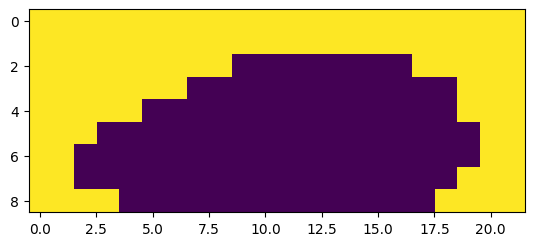

In [8]:
plt.imshow(mask)

In [9]:
selem = morphology.disk(border)



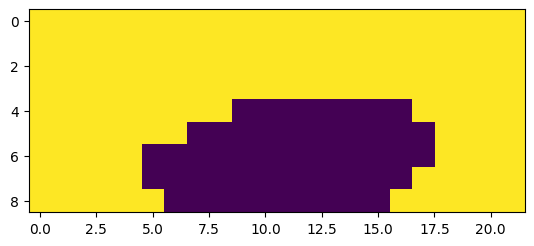

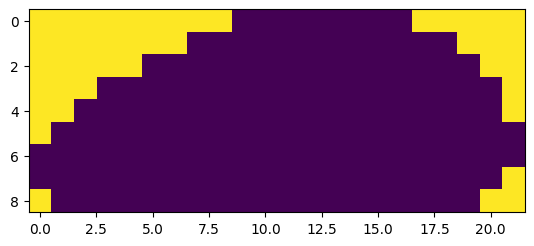

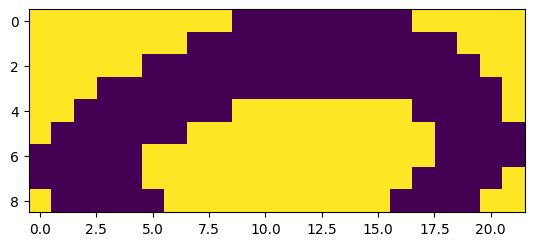

In [21]:
inner = morphology.dilation(mask, selem)
bigger = morphology.erosion(mask, selem)
outer = np.invert(inner ^ bigger)
plt.imshow(inner)
plt.show()
plt.imshow(bigger)
plt.show()
plt.imshow(outer)
plt.show()

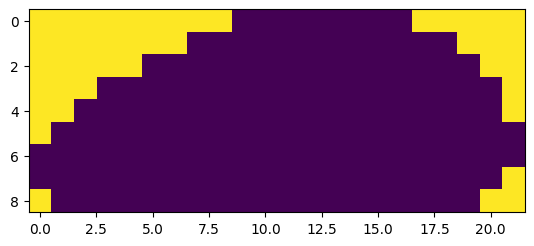

In [11]:
plt.imshow(morphology.erosion(mask, selem))

In [13]:
dil

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False